# import library, load csv

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import regex

In [16]:
def str2list(x: str) -> list:
    '''문자열을 리스트로 변환하는 함수'''
    return x[1:-1].split(', ')

def split_location(x: str) -> list:
    '''
    Parameters
    ----------
    x : str
        location 데이터

    Returns
    -------
    res : list
        location 데이터를 나눈 뒤, 정제한 결과를 반환합니다.
        순서는 country, state, city, ... 입니다.
    '''
    res = x.split(',')
    res = [i.strip().lower() for i in res]
    res = [regex.sub(r'[^a-zA-Z/ ]', '', i) for i in res]  # remove special characters
    res = [i if i not in ['n/a', ''] else np.nan for i in res]  # change 'n/a' into NaN
    res.reverse()  # reverse the list to get country, state, city, ... order

    for i in range(len(res)-1, 0, -1):
        if (res[i] in res[:i]) and (not pd.isna(res[i])):  # remove duplicated values if not NaN
            res.pop(i)

    return res


def process_context_data(users, books):
    """
    Parameters
    ----------
    users : pd.DataFrame
        users.csv를 인덱싱한 데이터
    books : pd.DataFrame
        books.csv를 인덱싱한 데이터
    ratings1 : pd.DataFrame
        train 데이터의 rating
    ratings2 : pd.DataFrame
        test 데이터의 rating
    
    Returns
    -------
    label_to_idx : dict
        데이터를 인덱싱한 정보를 담은 딕셔너리
    idx_to_label : dict
        인덱스를 다시 원래 데이터로 변환하는 정보를 담은 딕셔너리
    train_df : pd.DataFrame
        train 데이터
    test_df : pd.DataFrame
        test 데이터
    """

    users_ = users.copy()
    books_ = books.copy()

    # 데이터 전처리 (전처리는 각자의 상황에 맞게 진행해주세요!)
    books_['category'] = books_['category'].apply(lambda x: str2list(x)[0] if not pd.isna(x) else np.nan)
    books_['language'] = books_['language'].fillna(books_['language'].mode()[0])
    books_['publication_range'] = books_['year_of_publication'].apply(lambda x: x // 10 * 10)  # 1990년대, 2000년대, 2010년대, ...

    users_['age'] = users_['age'].fillna(users_['age'].mode()[0])
    users_['age_range'] = users_['age'].apply(lambda x: x // 10 * 10)  # 10대, 20대, 30대, ...

    users_['location_list'] = users_['location'].apply(lambda x: split_location(x)) 
    users_['location_country'] = users_['location_list'].apply(lambda x: x[0])
    users_['location_state'] = users_['location_list'].apply(lambda x: x[1] if len(x) > 1 else np.nan)
    users_['location_city'] = users_['location_list'].apply(lambda x: x[2] if len(x) > 2 else np.nan)
    for idx, row in users_.iterrows():
        if (not pd.isna(row['location_state'])) and pd.isna(row['location_country']):
            fill_country = users_[users_['location_state'] == row['location_state']]['location_country'].mode()
            fill_country = fill_country[0] if len(fill_country) > 0 else np.nan
            users_.loc[idx, 'location_country'] = fill_country
        elif (not pd.isna(row['location_city'])) and pd.isna(row['location_state']):
            if not pd.isna(row['location_country']):
                fill_state = users_[(users_['location_country'] == row['location_country']) 
                                    & (users_['location_city'] == row['location_city'])]['location_state'].mode()
                fill_state = fill_state[0] if len(fill_state) > 0 else np.nan
                users_.loc[idx, 'location_state'] = fill_state
            else:
                fill_state = users_[users_['location_city'] == row['location_city']]['location_state'].mode()
                fill_state = fill_state[0] if len(fill_state) > 0 else np.nan
                fill_country = users_[users_['location_city'] == row['location_city']]['location_country'].mode()
                fill_country = fill_country[0] if len(fill_country) > 0 else np.nan
                users_.loc[idx, 'location_country'] = fill_country
                users_.loc[idx, 'location_state'] = fill_state

               
    
    users_ = users_.drop(['location'], axis=1)

    return users_, books_

In [17]:
import os
if os.path.exists('../data/eda_df.csv'):
    eda_df = pd.read_csv('../data/eda_df.csv', index_col=0)
else:
    users = pd.read_csv('../data/users.csv', index_col=0)
    books = pd.read_csv('../data/books.csv', index_col=0)
    test_ratings = pd.read_csv('../data/test_ratings.csv')
    train_ratings = pd.read_csv('../data/train_ratings.csv')
    users, books = process_context_data(users, books)

    # _type feature 추가
    test_ratings['_type'] = 'test'
    train_ratings['_type'] = 'train'

    # test train concat
    eda_df = pd.concat([train_ratings, test_ratings], axis=0)
    eda_df = eda_df.merge(users, on='user_id', how='left')
    eda_df = eda_df.merge(books, on='isbn', how='left')
    eda_df.to_csv('../data/eda_df.csv')

# EDA

In [18]:
eda_df.head()

,user_id,isbn,rating,_type,age,age_range,location_list,location_country,location_state,location_city,book_title,book_author,year_of_publication,publisher,img_url,language,category,summary,img_path,publication_range
0,8,0002005018,4,train,29.0,20.0,"[canada, ontario, timmins]",canada,ontario,timmins,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,en,'Actresses',"In a small town in Canada, Clara Callan reluct...",images/0002005018.01.THUMBZZZ.jpg,2000.0
1,67544,0002005018,7,train,30.0,30.0,"[canada, ontario, toronto]",canada,ontario,toronto,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,en,'Actresses',"In a small town in Canada, Clara Callan reluct...",images/0002005018.01.THUMBZZZ.jpg,2000.0
2,123629,0002005018,8,train,29.0,20.0,"[canada, ontario, kingston]",canada,ontario,kingston,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,en,'Actresses',"In a small town in Canada, Clara Callan reluct...",images/0002005018.01.THUMBZZZ.jpg,2000.0
3,200273,0002005018,8,train,29.0,20.0,"[canada, ontario, comber]",canada,ontario,comber,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,en,'Actresses',"In a small town in Canada, Clara Callan reluct...",images/0002005018.01.THUMBZZZ.jpg,2000.0
4,210926,0002005018,9,train,29.0,20.0,"[canada, ontario, guelph]",canada,ontario,guelph,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,en,'Actresses',"In a small town in Canada, Clara Callan reluct...",images/0002005018.01.THUMBZZZ.jpg,2000.0


In [19]:
# null 비율
eda_df.isnull().mean() * 100

user_id                 0.000000
isbn                    0.000000
rating                  0.000000
_type                   0.000000
age                     0.000000
age_range               0.000000
location_list           0.000000
location_country        1.971348
location_state          2.579180
location_city           5.901266
book_title              0.000000
book_author             0.000261
year_of_publication     0.000000
publisher               0.000000
img_url                 0.000000
language                0.000000
category               39.515612
summary                38.820425
img_path                0.000000
publication_range       0.000000
dtype: float64

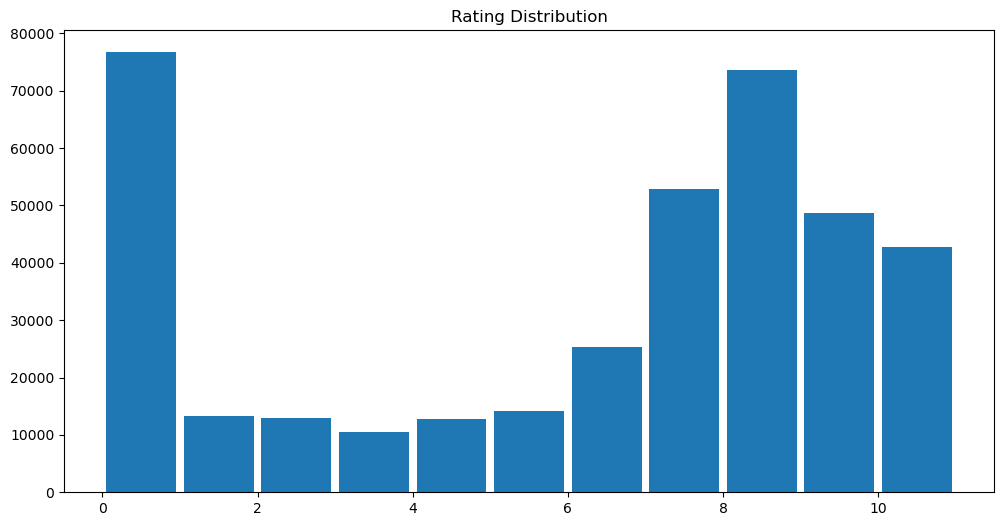

In [20]:
# 평점 분포
plt.figure(figsize=(12, 6))
plt.hist(eda_df['rating'], bins=11, range=(0, 11), rwidth= 0.9)
plt.title('Rating Distribution')
plt.show()

# 유저 별 평점을 준 영화 개수의 분포

In [21]:
# 각 유저마다 rating을 매긴 영화의 수
users['num_ratings'] = train_ratings.groupby('user_id').size()

Text(0.5, 1.0, 'Number of Ratings per User (Train)')

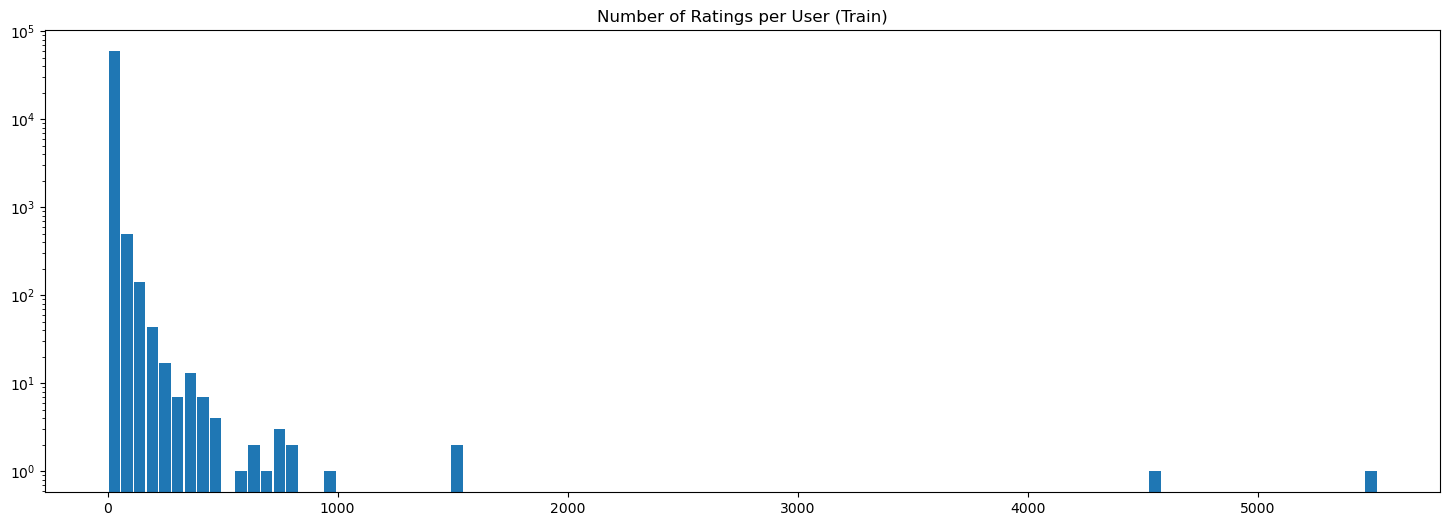

In [22]:
# 평가 횟수에 대한 히스토그램 2 * 1 subplot
plt.figure(figsize=(18, 6))
plt.hist(users['num_ratings'], bins=100, rwidth= 0.9)
plt.yscale('log')
plt.title('Number of Ratings per User (Train)')

# 평점 분포

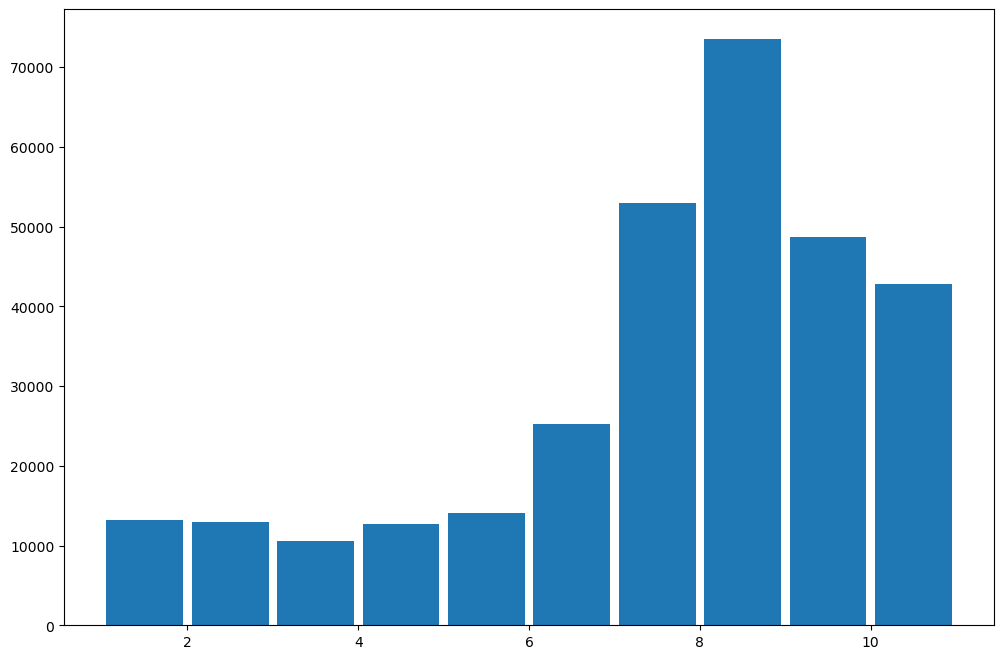

In [79]:
# 전체 평점 분포
plt.figure(figsize=(12, 8))
plt.hist(train_ratings['rating'], bins=10, range=(1, 11), rwidth=0.9)
plt.show()

In [93]:
# 1000회 이상 평가한 유저 ID
active_users = users[users['num_ratings'] >= 400].index
active_users

Index([ 11676, 177458, 197659,  16795,  35859, 101851, 153662, 204864,  23902,
        56399,  93047,  95359, 171118, 182085, 185233, 235105, 158295,  98391,
       114368,  76499, 189835, 248718],
      dtype='int64', name='user_id')

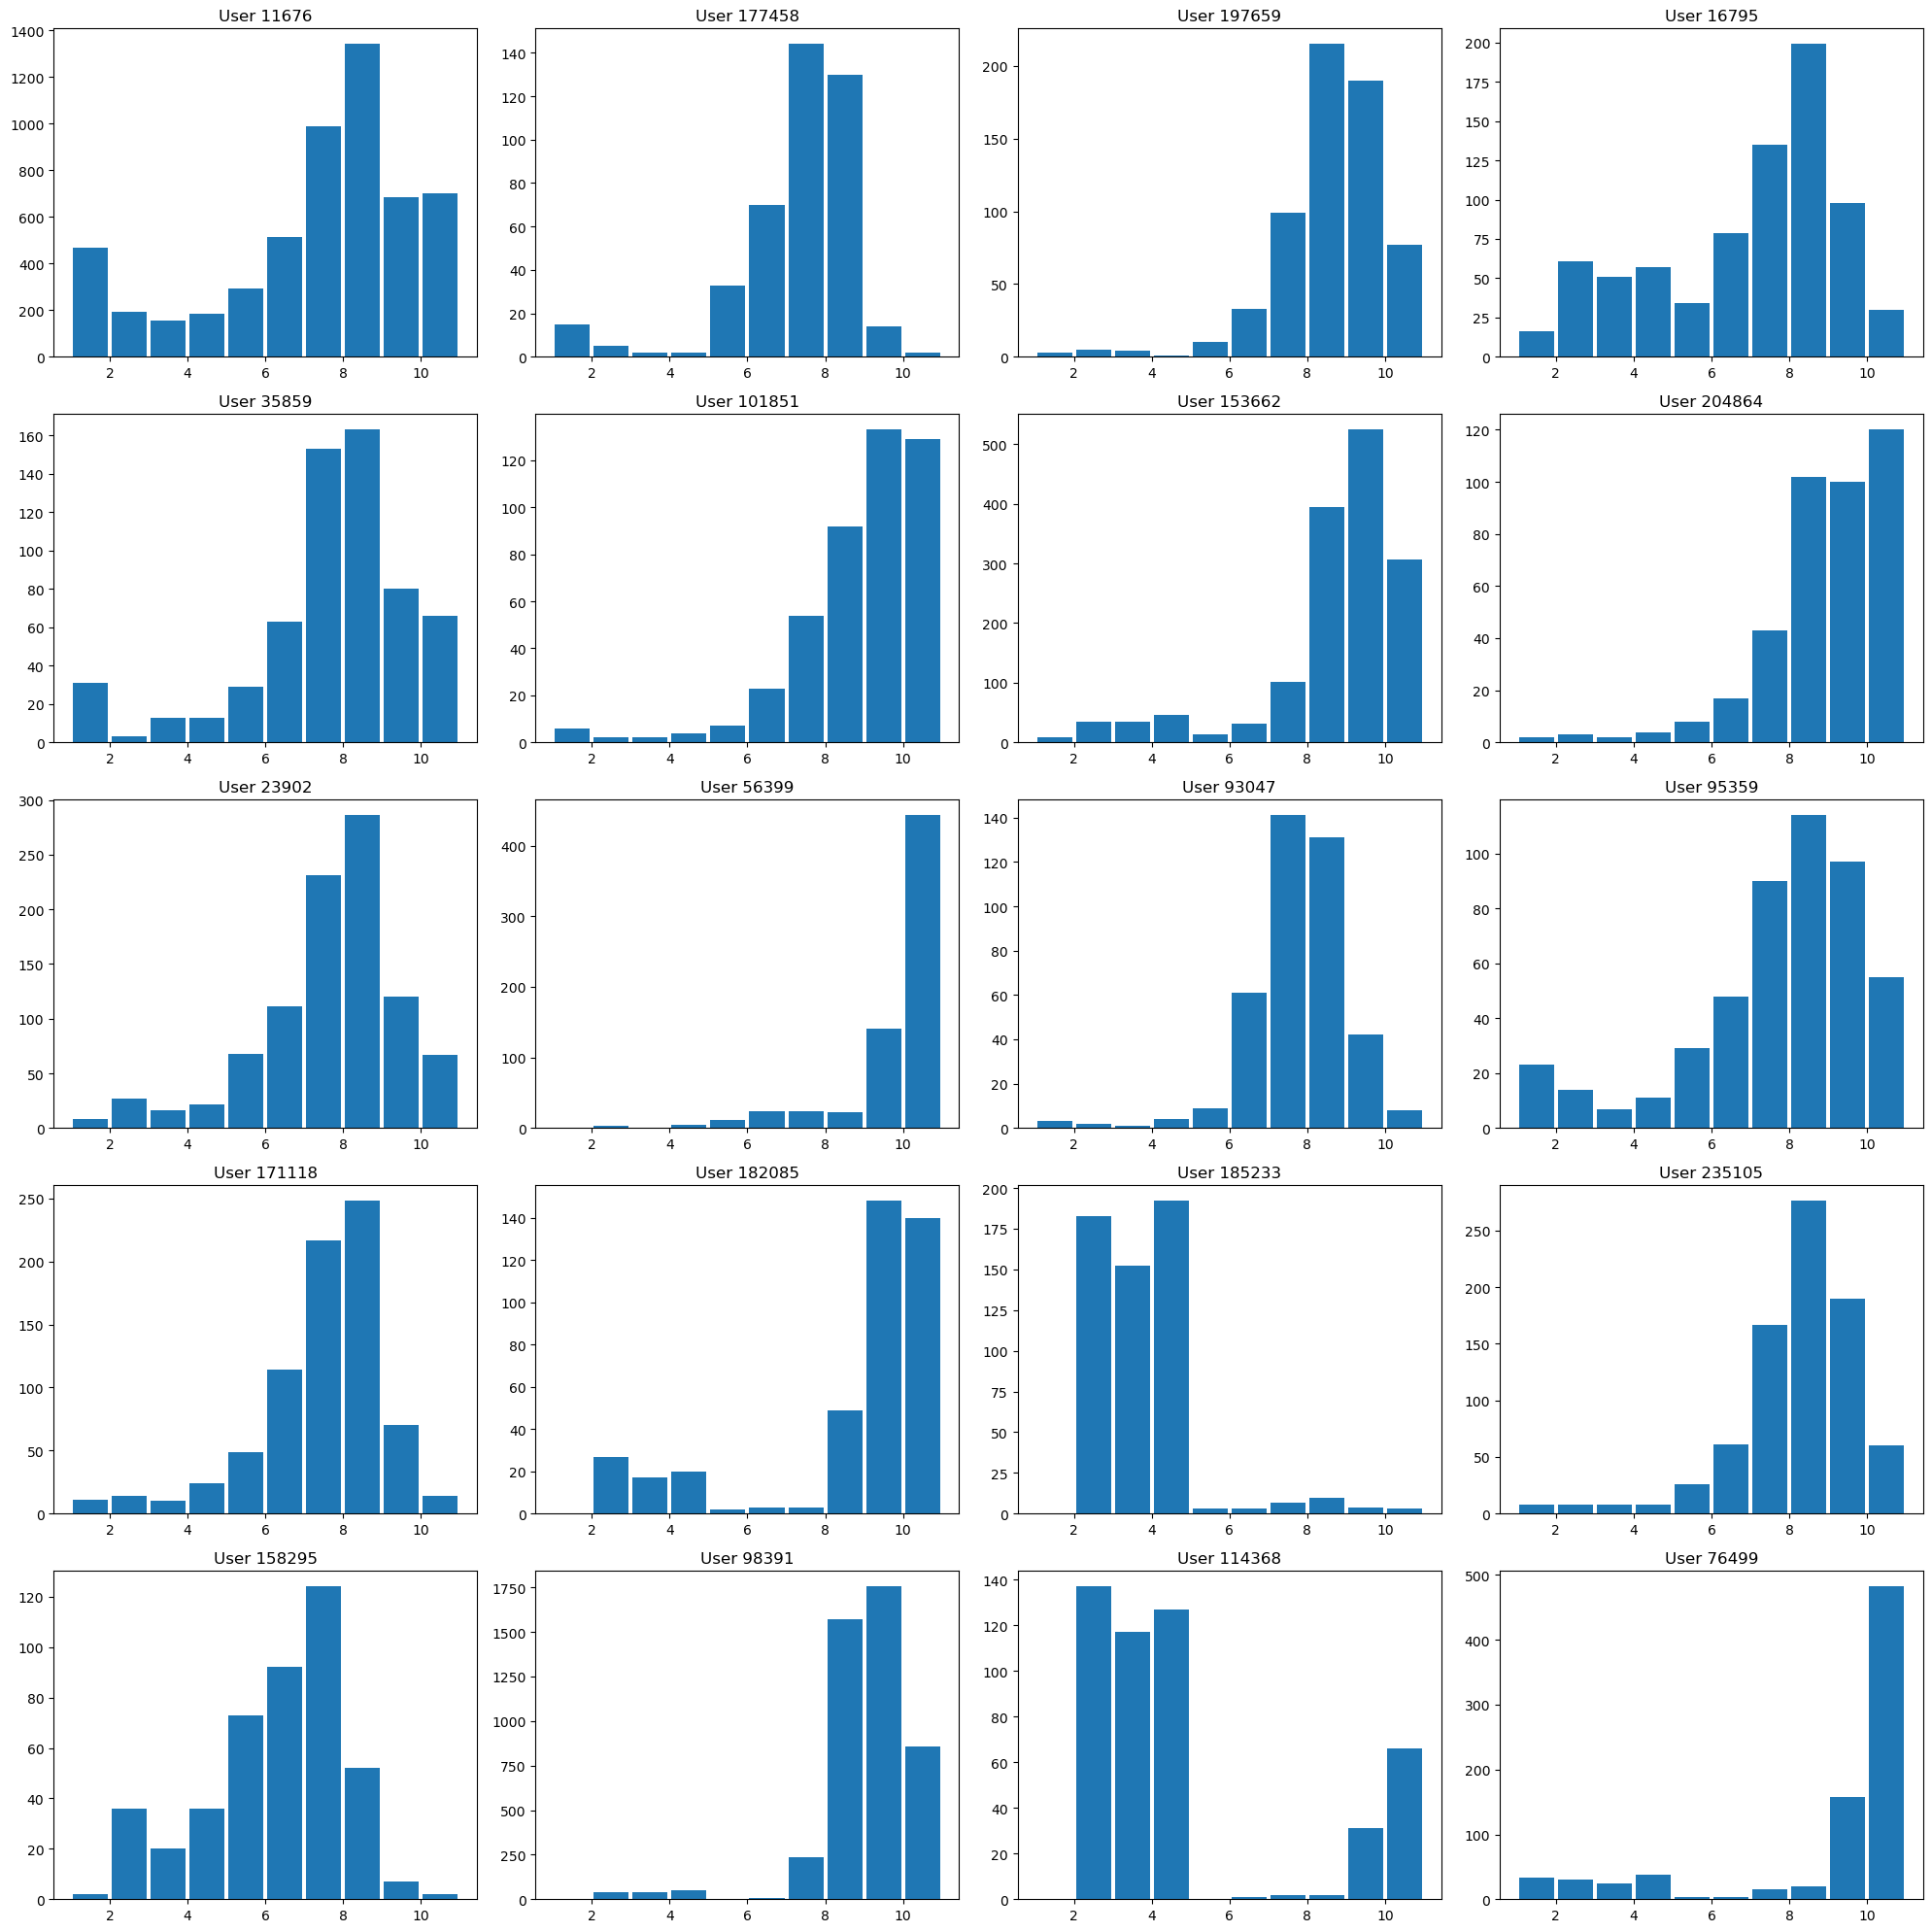

In [94]:
# 11676, 153662, 98391, 189835 유저의 rating plot
# sub plot
figs, axes = plt.subplots(5, 4, figsize=(20, 20))
for i, user_id in enumerate(active_users[:20], 1):
    ax = axes[(i-1)//4, (i-1)%4]
    user_rating = train_ratings[train_ratings['user_id'] == user_id]
    ax.hist(user_rating['rating'], bins=10, range=(1, 11), rwidth=0.9)
    ax.set_title(f'User {user_id}')
plt.tight_layout()
plt.show()

# Sparsity

In [23]:
# books
books = pd.read_csv('../data/books.csv', index_col=0)

In [24]:
num_ratings = train_ratings.shape[0]
num_books = books.shape[0]
num_users = users.shape[0]

sparsity = 100 * (1 - num_ratings / (num_books * num_users))
print(f"Book lens: {num_books}, User lens: {num_users}, Num ratings: {num_ratings}, Sparsity: {sparsity:.10f}%")

Book lens: 149570, User lens: 68092, Num ratings: 306795, Sparsity: 99.9969876343%


# Model Test 분포

In [25]:
ResNet_DeepFM_submit = pd.read_csv('../data/ResNet_DeepFM_baseline.csv')
NCF_submit = pd.read_csv('../data/NCF_baseline.csv')

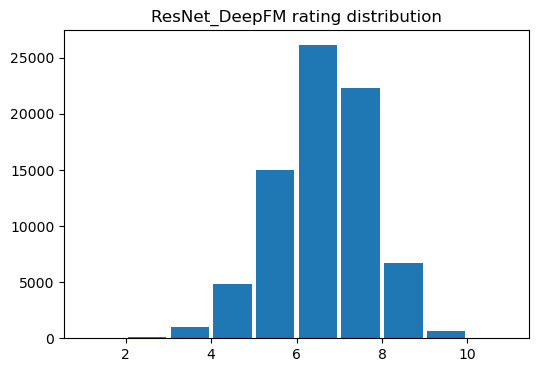

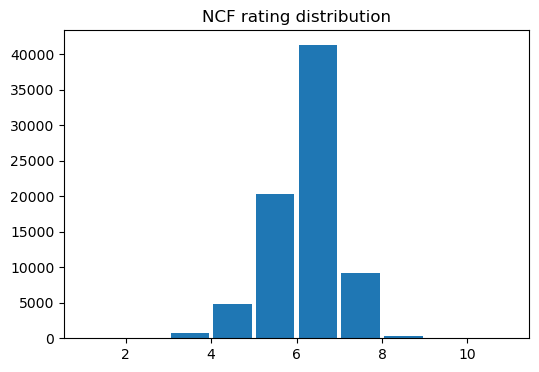

In [26]:
# rating 분포
plt.figure(figsize=(6, 4))
plt.hist(ResNet_DeepFM_submit['rating'], bins=10, range=(1, 11), rwidth=0.9)
plt.title('ResNet_DeepFM rating distribution')
plt.show()

plt.figure(figsize=(6, 4))
plt.hist(NCF_submit['rating'], bins=10, range=(1, 11), rwidth=0.9)
plt.title('NCF rating distribution')
plt.show()

# User Age

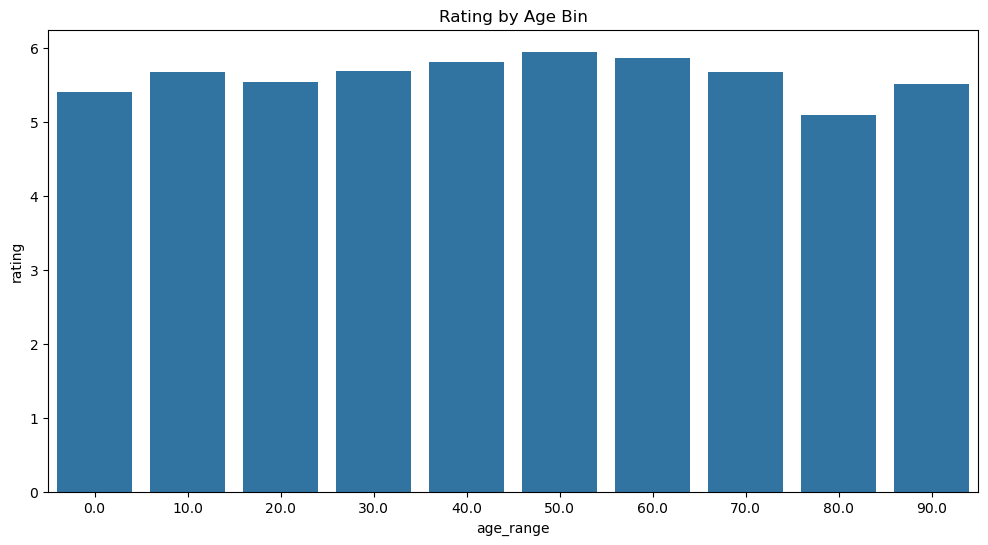

In [27]:
# age bin 별 rating 평균
age_rating = eda_df.groupby('age_range')['rating'].mean()
plt.figure(figsize=(12, 6))
sns.barplot(x=age_rating.index, y=age_rating)
plt.title('Rating by Age Bin')
plt.show()

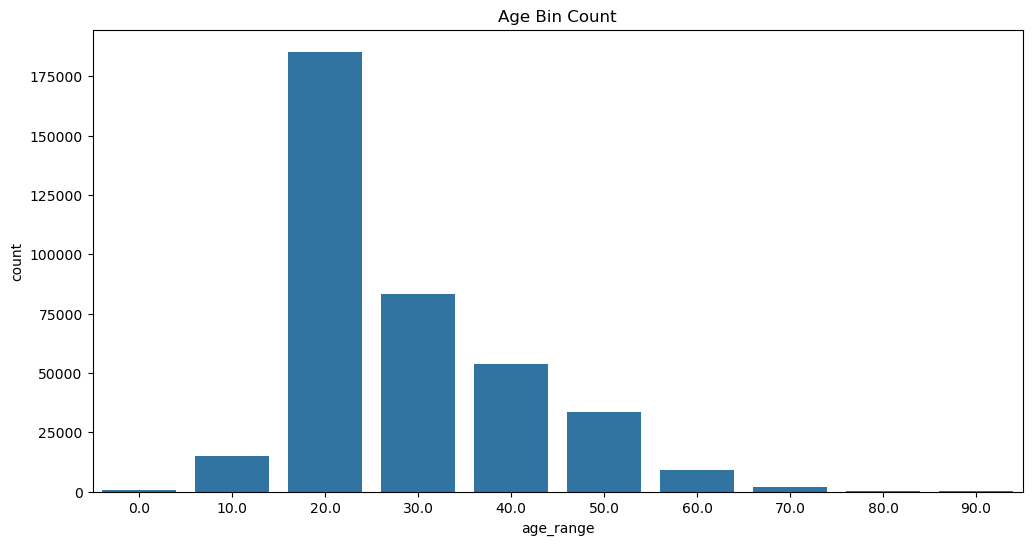

In [28]:
# bin 별 count plot
plt.figure(figsize=(12, 6))
sns.countplot(x='age_range', data=eda_df)
plt.title('Age Bin Count')
plt.show()
# Nan -> 20-30으로 대체

In [ ]:
# 로그인, 미 로그인 시 점수를 다르게 주는 방법 활용
# 로그인을 했다 -> 별점 리뷰 K개 이상 -> 추천 모델로 적용
# 로그인을 안했다 -> 별점 리뷰 K개 미만 -> Item-User matrix 활용 X, 컨텐츠 기반으로.

In [33]:
# review 1개인 유저와 2개 이상인 유저 수
print('1개인 유저 수:', users[users['num_ratings'] == 1].shape[0])
print('2개 이상인 유저 수:', users[users['num_ratings'] > 1].shape[0])

1개인 유저 수: 34617
2개 이상인 유저 수: 25186


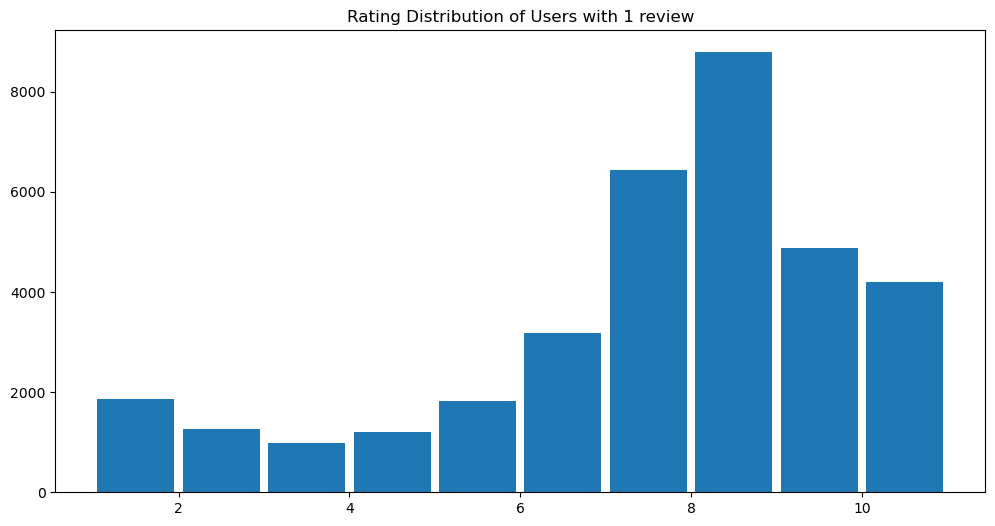

In [34]:
# 리뷰 1개인 유저 id 저장
one_review_user = users[users['num_ratings'] == 1].index

# 리뷰 1개인 유저 rating 분포
plt.figure(figsize=(12, 6))
plt.hist(train_ratings[train_ratings['user_id'].isin(one_review_user)]['rating'], bins=10, range=(1, 11), rwidth=0.9)
plt.title('Rating Distribution of Users with 1 review')
plt.show()

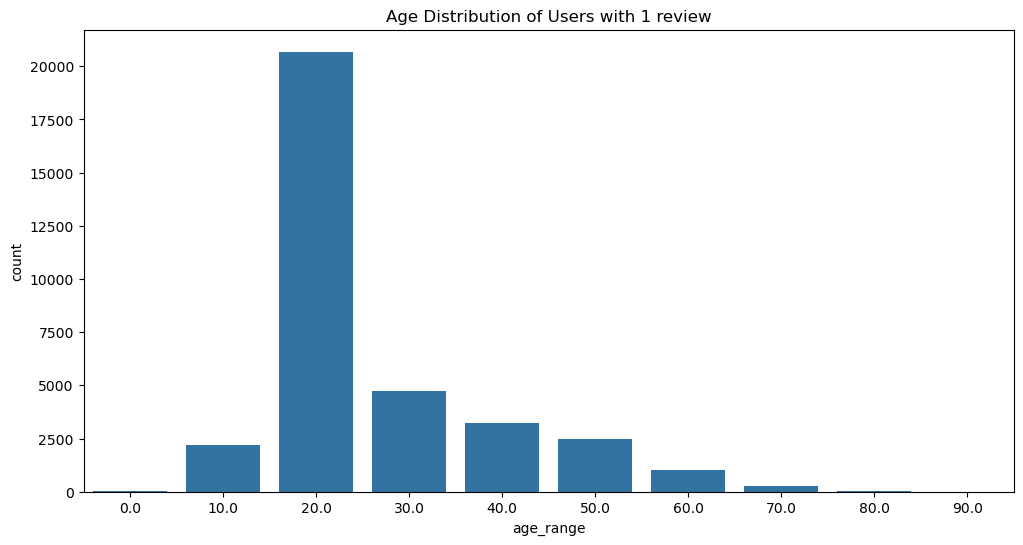

In [35]:
# 리뷰 1개인 유저의 나이 분포
plt.figure(figsize=(12, 6))
sns.countplot(x='age_range', data=users[users.index.isin(one_review_user)])
plt.title('Age Distribution of Users with 1 review')
plt.show()

In [43]:
# 리뷰 1개인 유저 test에 몇번 등장하는지
one_review_user_test = test_ratings[test_ratings['user_id'].isin(one_review_user)]
print(len(one_review_user_test))
print(len(test_ratings))
# 비율
print(len(one_review_user_test) / len(test_ratings) * 100)

3860
76699
5.0326601389848635
